# Anomaly Detection in IoT Attacks

## Dataset Overview
- **Dataset**: The dataset used here is a combination of IoT network logs (not UNSW_2018_IoT as mentioned earlier, which is incorrect). It contains network traffic data with features like IP addresses, protocols, and SCADA tags.
- **Training Data**: Concatenated from two files (`2015-12-28_113021_98.log.part12_sorted.csv` and `2015-12-31_233049_114.log.part11_sorted.csv`).
- **Test Data**: From `2015-12-28_164554_99.log.part01_sorted.csv`.
- **Goal**: Classify data into 2 classes (normal: 0, anomaly: 1) using an Artificial Neural Network (ANN).

## Steps
1. Data Preprocessing: Handle IPs, categorical features, and scaling.
2. Dimensionality Reduction: Apply SMOTE and PCA.
3. Model Training: Build and train an ANN.
4. Evaluation: Assess model performance.

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, BatchNormalization
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.metrics import classification_report

In [2]:
data1 = pd.read_csv("2015-12-28_113021_98.log.part12_sorted.csv")
data2 = pd.read_csv("2015-12-31_233049_114.log.part11_sorted.csv")
data3 = pd.read_csv("2015-12-28_164554_99.log.part01_sorted.csv")
# Gộp theo hàng (axis=0)
data = pd.concat([data1, data2, data3], axis=0, ignore_index=True)

data.head()

,num,date,time,orig,type,i/f_name,i/f_dir,src,dst,proto,appi_name,proxy_src_ip,Modbus_Function_Code,Modbus_Function_Description,Modbus_Transaction_ID,SCADA_Tag,Modbus_Value,service,s_port,Tag
0,5500001,28-Dec-15,10:16:36,192.168.1.48,log,eth1,outbound,192.168.1.60,192.168.1.20,tcp,CIP_read_tag_service,192.168.1.60,76.0,Read Tag Service - Response,6884.0,HMI_AIT202,0xae 0x70 0x07 0x41; 0x00 0x00 0x00 0x00; 0x00...,44818.0,53250.0,0
1,5500002,28-Dec-15,10:16:36,192.168.1.48,log,eth1,outbound,192.168.1.10,192.168.1.20,tcp,CIP_read_tag_service,192.168.1.10,76.0,Read Tag Service - Response,3257.0,HMI_FIT201,0x00 0x00 0x00 0x00; 0x00 0x00 0x00 0x00; 0x00...,44818.0,54592.0,0
2,5500003,28-Dec-15,10:16:36,192.168.1.48,log,eth1,outbound,192.168.1.30,192.168.1.40,tcp,CIP_read_tag_service,192.168.1.30,76.0,Read Tag Service,49808.0,HMI_LIT401,Number of Elements: 1,44818.0,52544.0,0
3,5500004,28-Dec-15,10:16:36,192.168.1.48,log,eth1,outbound,192.168.1.20,192.168.1.30,tcp,CIP_read_tag_service,192.168.1.20,76.0,Read Tag Service,47461.0,HMI_LIT301,Number of Elements: 1,44818.0,53326.0,0
4,5500005,28-Dec-15,10:16:36,192.168.1.48,log,eth1,outbound,192.168.1.60,192.168.1.10,tcp,CIP_read_tag_service,192.168.1.60,76.0,Read Tag Service,6490.0,HMI_LIT101,Number of Elements: 1,44818.0,53260.0,0


In [3]:
data['Tag'].value_counts()

Tag
0    1004042
1     495958
Name: count, dtype: int64

## 2. Xử lý dữ liệu

In [4]:
# khai báo thư viện
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import socket
import struct

### 1. Xử lý NaN

In [5]:
X = data.drop(columns=['Tag'])  # bỏ cột nhãn
# bỏ các nhãn không cần thiết
columns_to_drop = ['num', 'date', 'time', 'Modbus_Value']
X = data.drop(columns=columns_to_drop)
X = X.dropna()                     # xóa tất cả hàng có NaN

### 2. Xử lý các số liệu là địa chỉ ip

In [6]:
# Định nghĩa hàm chuyển IP -> số nguyên
def ip_to_int(ip):
    try:
        return struct.unpack("!I", socket.inet_aton(str(ip)))[0]
    except:
        return np.nan  # Trả về NaN để dễ xử lý

data['src'] = data['src'].apply(ip_to_int)
data['orig'] = data['orig'].apply(ip_to_int)
data['dst'] = data['dst'].apply(ip_to_int)
data['proxy_src_ip'] = data['proxy_src_ip'].apply(ip_to_int)

### 3. Xử lý các số liệu là string 

In [7]:
le = LabelEncoder()
categorical_columns = ['appi_name', 'type', 'i/f_name', 'i/f_dir', 'proto', 
                      'SCADA_Tag', 'Modbus_Function_Description']
for col in categorical_columns:
    data[col] = le.fit_transform(data[col])

### 4. chuẩn hóa dữ liệu

In [8]:
#  Lấy lại X từ data sau khi mã hóa, đảm bảo bao gồm các cột đã mã hóa
X = data.drop(columns=columns_to_drop)
# Xóa các hàng có NaN và đồng bộ với y
X = X.dropna()
# Lấy chỉ số của các hàng còn lại sau khi xóa NaN
valid_indices = X.index
# Đồng bộ y với các hàng còn lại
y = data.loc[valid_indices, 'Tag']

In [9]:
#  Lọc ra chỉ dữ liệu số (đề phòng có string)
X = X.select_dtypes(include=[np.number])

#  Scale dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
print(X.dtypes)

orig                             int64
type                             int64
i/f_name                         int64
i/f_dir                          int64
src                            float64
dst                            float64
proto                            int64
appi_name                        int64
proxy_src_ip                   float64
Modbus_Function_Code           float64
Modbus_Function_Description      int64
Modbus_Transaction_ID          float64
SCADA_Tag                        int64
service                        float64
s_port                         float64
Tag                              int64
dtype: object


In [11]:
data['Tag'].value_counts()

Tag
0    1004042
1     495958
Name: count, dtype: int64

## 3. Train mô hình AI bằng phương pháp ANN

### 1. Cân bằng và giảm chiều dữ liệu

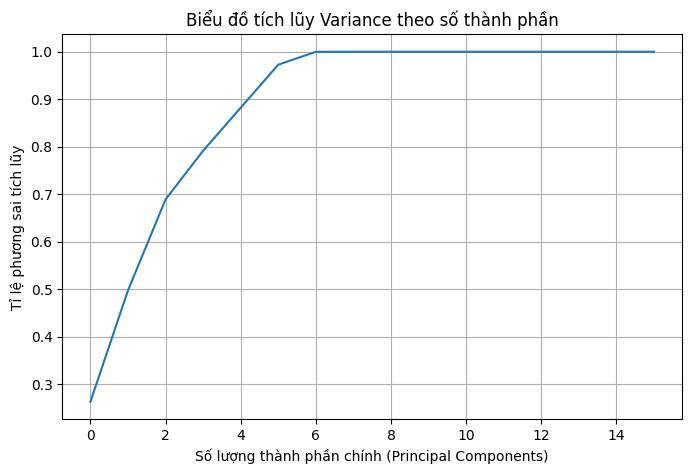

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Áp dụng SMOTE trên X_scaled (trước PCA)
smote = SMOTE(random_state=42)
X_scaled_smote, y_smote = smote.fit_resample(X_scaled, y)

# 1. Khởi tạo PCA
pca = PCA()

# 2. Fit PCA
pca.fit(X_scaled_smote)

# 3. Phân tích tỉ lệ phương sai (Variance ratio)
explained_variance = pca.explained_variance_ratio_

# 4. Vẽ biểu đồ để xem nên chọn bao nhiêu thành phần
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Số lượng thành phần chính (Principal Components)')
plt.ylabel('Tỉ lệ phương sai tích lũy')
plt.title('Biểu đồ tích lũy Variance theo số thành phần')
plt.grid(True)
plt.show()


In [13]:
# theo bảng ta chọn số thành phần
pca = PCA(n_components=4)
X_pca_smote = pca.fit_transform(X_scaled_smote)


In [14]:
import pandas as pd

# Tạo bảng feature importance
components = pd.DataFrame(pca.components_, columns=X.columns)

# Xem thành phần đầu tiên
print(components.iloc[0])


orig                          -0.000000e+00
type                           5.773084e-01
i/f_name                      -0.000000e+00
i/f_dir                        3.469447e-18
src                            6.240936e-03
dst                           -4.241777e-03
proto                         -1.084202e-19
appi_name                      5.773084e-01
proxy_src_ip                   6.240936e-03
Modbus_Function_Code          -5.773084e-01
Modbus_Function_Description    3.906542e-03
Modbus_Transaction_ID          6.169623e-04
SCADA_Tag                     -5.730659e-03
service                       -0.000000e+00
s_port                        -7.709635e-04
Tag                           -1.456551e-04
Name: 0, dtype: float64


### 2. Xây dựng mô hình ANN

In [15]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

X_train, X_test, y_train, y_test = train_test_split(X_pca_smote, y_smote, test_size=0.1, random_state=42)

# Tạo mô hình ANN
model = Sequential()

# Thêm lớp đầu vào (input layer) và lớp ẩn (hidden layer)
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # 64 nút, kích thước đầu vào là số thành phần chính sau PCA
model.add(Dense(32, activation='relu'))  # Lớp ẩn thứ 2
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Thêm lớp đầu ra (output layer)
model.add(Dense(1, activation='sigmoid'))  # sigmoid nếu là phân loại nhị phân (binary classification)

# Biên dịch mô hình
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


c:\Users\mayti\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 3. Train mô hình ANN

In [16]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))
y_pred_prob = model.predict(X_test)           # Dự đoán xác suất
y_pred = (y_pred_prob > 0.5).astype(int)      # Chuyển thành nhãn nhị phân


Epoch 1/10
14119/14119 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.9968 - loss: 0.0094 - val_accuracy: 1.0000 - val_loss: 1.7624e-09
Epoch 2/10
14119/14119 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 1.0000 - loss: 4.4788e-05 - val_accuracy: 1.0000 - val_loss: 3.1665e-12
Epoch 3/10
14119/14119 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - accuracy: 1.0000 - loss: 5.1307e-05 - val_accuracy: 1.0000 - val_loss: 1.4993e-12
Epoch 4/10
14119/14119 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 1.0000 - loss: 1.3267e-04 - val_accuracy: 1.0000 - val_loss: 1.7973e-13
Epoch 5/10
14119/14119 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 1.0000 - loss: 4.9002e-05 - val_accuracy: 1.0000 - val_loss: 4.5383e-14
Epoch 6/10
14119/14119 ━━━━━━━━━━━━━━━━━━━━ 87s 6ms/step - accuracy: 1.0000 - loss: 5.2108e-06 - val_accuracy: 1.0000 - val_loss: 2.0550e-14
Epoch 7/10
14119/14119 ━━━━━━━━━━━━━━━━━━━━ 77s 5ms/step - accuracy: 1.0000 - loss: 1.4618e-04 - val_accuracy: 1.0000 - val_loss: 2.1218e-14
Epoch 8/10
14119/

## 4. Vẽ biểu đồ và đánh giá mô hình

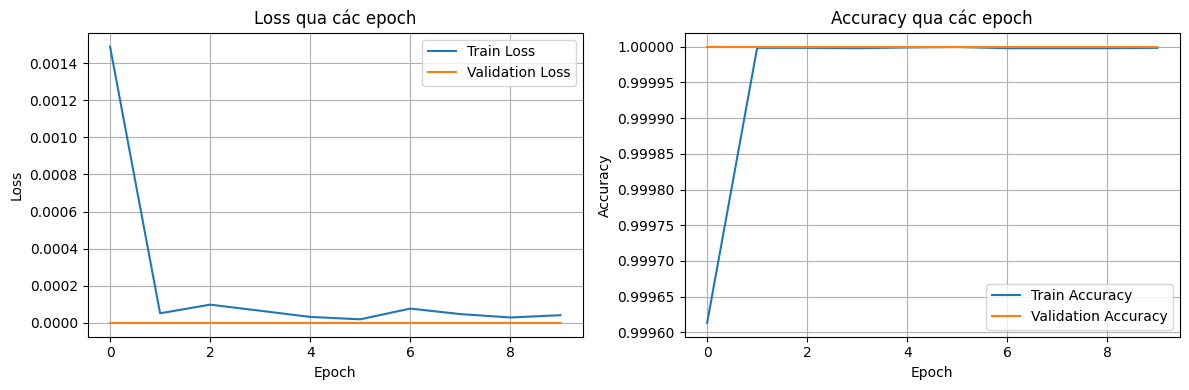

In [17]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss qua các epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Vẽ biểu đồ accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy qua các epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [18]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")
print(classification_report(y_test,y_pred))

6275/6275 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 1.0000 - loss: 2.8652e-14
Loss: 2.858869689375751e-14, Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    100723
           1       1.00      1.00      1.00    100077

    accuracy                           1.00    200800
   macro avg       1.00      1.00      1.00    200800
weighted avg       1.00      1.00      1.00    200800

